한 행에 시계열에 대한 데이터가 다 들어가야한다. <br/>
컬럼3, 6, 9, ~ 240
한 행의 답이 20개의 답이 되어줄 것이다.


In [1]:
%pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb  # LightGBM
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.


In [5]:
df = pd.read_csv("./data/rainfall_train.csv", encoding='utf-8', index_col=False)
df['prob_0'] = 100 - df['rainfall_train.v01']
df['prob_1'] = df['rainfall_train.v01'] - df['rainfall_train.v02']
df['prob_2'] = df['rainfall_train.v02'] - df['rainfall_train.v03']
df['prob_3'] = df['rainfall_train.v03'] - df['rainfall_train.v04']
df['prob_4'] = df['rainfall_train.v04'] - df['rainfall_train.v05']
df['prob_5'] = df['rainfall_train.v05'] - df['rainfall_train.v06']
df['prob_6'] = df['rainfall_train.v06'] - df['rainfall_train.v07']
df['prob_7'] = df['rainfall_train.v07'] - df['rainfall_train.v08']
df['prob_8'] = df['rainfall_train.v08'] - df['rainfall_train.v09']
df['prob_9'] = df['rainfall_train.v09']
df.drop(columns=['rainfall_train.v01',
                 'rainfall_train.v02',
                 'rainfall_train.v03',
                 'rainfall_train.v04',
                 'rainfall_train.v05',
                 'rainfall_train.v06',
                 'rainfall_train.v07',
                 'rainfall_train.v08',
                 'rainfall_train.v09'], inplace=True)
df = df[df['rainfall_train.vv'] >= 0]
df["expected"] = (df["prob_0"] * 0\
                +df["prob_1"] * 10\
                +df["prob_2"] * 20\
                +df["prob_3"] * 30\
                +df["prob_4"] * 40\
                +df["prob_5"] * 50\
                +df["prob_6"] * 60\
                +df["prob_7"] * 70\
                +df["prob_8"] * 80\
                +df["prob_9"] * 90) / 100
df.drop(columns=[
    'Unnamed: 0', 'rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour',
    "prob_0","prob_1","prob_2","prob_3","prob_4","prob_5","prob_6","prob_7","prob_8","prob_9"], inplace=True)
df

,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,expected
0,STN001,3,A,5,1,12,0.0,0,0.0
1,STN001,6,A,5,1,15,0.0,0,0.0
2,STN001,9,A,5,1,18,0.0,0,0.0
3,STN001,12,A,5,1,21,0.0,0,0.0
4,STN001,15,A,5,2,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
1457247,STN020,228,C,10,10,9,0.5,3,2.0
1457248,STN020,231,C,10,10,12,0.0,0,3.1
1457249,STN020,234,C,10,10,15,1.9,4,3.1
1457250,STN020,237,C,10,10,18,1.9,4,2.2


In [6]:
pivot_df = df.pivot_table(index=['rainfall_train.stn4contest', 
                                 'rainfall_train.ef_year', 
                                 'rainfall_train.ef_month', 
                                 'rainfall_train.ef_day', 
                                 'rainfall_train.ef_hour',
                                 'rainfall_train.vv',
                                 'rainfall_train.class_interval'
                                 ],
                          columns='rainfall_train.dh',
                          values='expected').reset_index()
pivot_df

rainfall_train.dh,rainfall_train.stn4contest,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,...,213,216,219,222,225,228,231,234,237,240
0,STN001,A,5,1,12,0.0,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,STN001,A,5,1,15,0.0,0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,STN001,A,5,1,18,0.0,0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,STN001,A,5,1,21,0.0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STN001,A,5,2,0,0.0,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77518,STN020,C,10,10,9,0.5,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.1
77519,STN020,C,10,10,12,0.0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.1,NaN,NaN,NaN
77520,STN020,C,10,10,15,1.9,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1,NaN,NaN
77521,STN020,C,10,10,18,1.9,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN


In [7]:
final_df = pivot_df.groupby([
    'rainfall_train.stn4contest', 
    'rainfall_train.ef_year', 
    'rainfall_train.ef_month', 
    'rainfall_train.ef_day', 
    'rainfall_train.ef_hour']).sum().reset_index()
final_df


rainfall_train.dh,rainfall_train.stn4contest,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,...,213,216,219,222,225,228,231,234,237,240
0,STN001,A,5,1,12,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,STN001,A,5,1,15,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,STN001,A,5,1,18,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,STN001,A,5,1,21,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,STN001,A,5,2,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77518,STN020,C,10,10,9,0.5,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.1
77519,STN020,C,10,10,12,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0
77520,STN020,C,10,10,15,1.9,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0
77521,STN020,C,10,10,18,1.9,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0


In [13]:
df[(df["rainfall_train.stn4contest"] == 'STN001') &
   	(df["rainfall_train.ef_year"] == 'A') &	
    (df["rainfall_train.ef_month"] == 8) & 
    (df["rainfall_train.ef_day"] == 1) &
    (df["rainfall_train.ef_hour"] == 12)
       ]

,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,expected
13274,STN001,231,A,8,1,12,28.1,8,31.2
13350,STN001,219,A,8,1,12,28.1,8,30.8
13426,STN001,207,A,8,1,12,28.1,8,30.8
13502,STN001,195,A,8,1,12,28.1,8,38.5
13578,STN001,183,A,8,1,12,28.1,8,40.5
13654,STN001,171,A,8,1,12,28.1,8,43.6
13730,STN001,159,A,8,1,12,28.1,8,41.8
13806,STN001,147,A,8,1,12,28.1,8,37.6
13882,STN001,135,A,8,1,12,28.1,8,40.6
13958,STN001,123,A,8,1,12,28.1,8,40.2


In [14]:
final_df[(final_df["rainfall_train.stn4contest"] == 'STN001') &
   	(final_df["rainfall_train.ef_year"] == 'A') &	
    (final_df["rainfall_train.ef_month"] == 8) & 
    (final_df["rainfall_train.ef_day"] == 1) &
    (final_df["rainfall_train.ef_hour"] == 12)
       ]

rainfall_train.dh,rainfall_train.stn4contest,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,...,213,216,219,222,225,228,231,234,237,240
731,STN001,A,8,1,12,28.1,8,61.7,0.0,0.0,...,0.0,0.0,30.8,0.0,0.0,0.0,31.2,0.0,0.0,0.0


In [16]:
# final_df.to_csv("./pivot_expected.csv", encoding='utf-8', index=False)

In [21]:
station_dfs = []
stations = [f'STN{str(i).zfill(3)}' for i in range(1, 21)]

for station in stations:
    station_df = final_df[final_df['rainfall_train.stn4contest'] == station]
    station_dfs.append(station_df)

# 리스트에 저장된 각 데이터프레임 출력 (확인용)
for i, station_df in enumerate(station_dfs):
    print(f"DataFrame for {stations[i]}:")
    station_df.drop(columns=['rainfall_train.stn4contest'], inplace=True)
    station_df.reset_index(drop=True, inplace=True)

DataFrame for STN001:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3885,C,10,10,9,0.8,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.4,0.0,0.0,0.0,1.3
3886,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0
3887,C,10,10,15,0.4,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0
3888,C,10,10,18,1.0,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,0.0



DataFrame for STN002:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,C,10,10,9,0.4,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,7.0
3883,C,10,10,12,0.3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0
3884,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
3885,C,10,10,18,0.2,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.8,0.0



DataFrame for STN003:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3880,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.7,0.0,0.0,0.0,9.4
3881,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.3,0.0,0.0,0.0
3882,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.3,0.0,0.0
3883,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.6,0.0



DataFrame for STN004:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.3,0.0,0.0,0.0,0.3
3872,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0
3873,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0
3874,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0



DataFrame for STN005:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.0,0.0,0.3
3858,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3859,C,10,10,15,0.5,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3860,C,10,10,18,0.6,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.8,0.0



DataFrame for STN006:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,C,10,10,9,8.4,6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.4
3853,C,10,10,12,1.1,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.4,0.0,0.0,0.0
3854,C,10,10,15,0.8,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,0.0,0.0
3855,C,10,10,18,1.8,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0



DataFrame for STN007:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.0,3.1
3884,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3885,C,10,10,15,0.9,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3886,C,10,10,18,3.1,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0



DataFrame for STN008:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.5,0.0,0.0,0.0,8.9
3885,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.8,0.0,0.0,0.0
3886,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.8,0.0,0.0
3887,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2,0.0



DataFrame for STN009:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.7,0.0,0.0,0.0,2.3
3872,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.4,0.0,0.0,0.0
3873,C,10,10,15,0.5,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.4,0.0,0.0
3874,C,10,10,18,0.4,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,0.0



DataFrame for STN010:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3855,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,3.2
3856,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0,0.0,0.0
3857,C,10,10,15,0.6,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0,0.0
3858,C,10,10,18,0.8,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0



DataFrame for STN011:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,2.2
3883,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.2,0.0,0.0,0.0
3884,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,0.0,0.0
3885,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0



DataFrame for STN012:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.4,0.0,0.0,0.0,6.5
3876,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.4,0.0,0.0,0.0
3877,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,0.0,0.0
3878,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.9,0.0



DataFrame for STN013:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.3,0.0,0.0,0.0,3.3
3871,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,0.0
3872,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0
3873,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0



DataFrame for STN014:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,C,10,10,9,0.6,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,3.4
3868,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0
3869,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0
3870,C,10,10,18,0.1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0



DataFrame for STN015:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,C,10,10,6,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,4.8,0.0
3877,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,4.8
3878,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,0.0
3879,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,0.0



DataFrame for STN016:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,4.0
3862,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3863,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3864,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0



DataFrame for STN017:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,C,10,10,9,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.0,0.0,3.4
3861,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.0
3862,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0
3863,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0



DataFrame for STN018:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,C,10,10,9,2.8,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.9,0.0,0.0,0.0,3.3
3873,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3874,C,10,10,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3875,C,10,10,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0



DataFrame for STN019:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,C,10,10,9,0.4,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,1.6
3888,C,10,10,12,0.7,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0,0.0,0.0
3889,C,10,10,15,0.9,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0,0.0
3890,C,10,10,18,1.6,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.8,0.0



DataFrame for STN020:


rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,3,6,9,12,...,213,216,219,222,225,228,231,234,237,240
0,A,5,1,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,5,1,15,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,5,1,18,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,5,1,21,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,5,2,0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,C,10,10,9,0.5,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.1
3854,C,10,10,12,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0
3855,C,10,10,15,1.9,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0
3856,C,10,10,18,1.9,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0


In [27]:

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0


def train(final_df):
    X = final_df.drop(columns=[
        # 'rainfall_train.dh',
        'rainfall_train.ef_year',	
        'rainfall_train.ef_month',	
        'rainfall_train.ef_day',	
        'rainfall_train.ef_hour',
        'rainfall_train.vv',
        'rainfall_train.class_interval'
    ])
    y = final_df[['rainfall_train.class_interval']]

    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    # 개별 모델 학습
    catboost = CatBoostClassifier(iterations=100, random_seed=42, silent=True)
    lgbm = LGBMClassifier(n_estimators=100, random_state=42)
    xgb = XGBClassifier(n_estimators=100, random_state=42)

    catboost.fit(X_train, y_train)
    lgbm.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    # 검증 데이터로 개별 모델 예측 (확률 값 사용)
    catboost_val_pred_proba = catboost.predict_proba(X_val)
    lgbm_val_pred_proba = lgbm.predict_proba(X_val)
    xgb_val_pred_proba = xgb.predict_proba(X_val)

    # Stacked features for meta model (확률 값 사용)
    stacked_features_proba = np.hstack((catboost_val_pred_proba, lgbm_val_pred_proba, xgb_val_pred_proba))
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
    meta_model.fit(stacked_features_proba, y_val)

    # 테스트 데이터로 최종 성능 평가 (확률 값 사용)
    catboost_test_pred_proba = catboost.predict_proba(X_test)
    lgbm_test_pred_proba = lgbm.predict_proba(X_test)
    xgb_test_pred_proba = xgb.predict_proba(X_test)

    stacked_test_features_proba = np.hstack((catboost_test_pred_proba, lgbm_test_pred_proba, xgb_test_pred_proba))
    final_pred = meta_model.predict(stacked_test_features_proba)
    results_df = pd.DataFrame({'estimated_rank': final_pred.ravel(), 'rainfall_train.class_interval': np.array(y_test).ravel()})
        # H, F, M, C 계산
    H, F, M, C = calculate_csi_components(results_df)

    # CSI 계산
    csi_value = calculate_csi(H, F, M)
    print(f"CSI: {csi_value}")
    print(f"H: {H}, F: {F}, M: {M}, C: {C}")


In [28]:
for temp_df in station_dfs:
    train(temp_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11288
[LightGBM] [Info] Number of data points in the train set: 2334, number of used features: 80
[LightGBM] [Info] Start training from score -0.181294
[LightGBM] [Info] Start training from score -4.171820
[LightGBM] [Info] Start training from score -3.948676
[LightGBM] [Info] Start training from score -3.905191
[LightGBM] [Info] Start training from score -3.884138
[LightGBM] [Info] Start training from score -3.360890
[LightGBM] [Info] Start training from score -3.804095
[LightGBM] [Info] Start training from score -3.884138
[LightGBM] [Info] Start training from score -4.922125
[LightGBM] [Info] Start training from score -5.190389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [21]:
print(pd.Series(final_pred).value_counts())


0    14280
5      633
6      234
7      128
4      101
8       36
2       35
3       31
9       27
Name: count, dtype: int64


In [22]:
predict_data = {
    "pred": final_pred
}
pred_df = pd.DataFrame(predict_data)

CSI: 0.12440570522979398
H: 314, F: 911, M: 1299, C: 12981


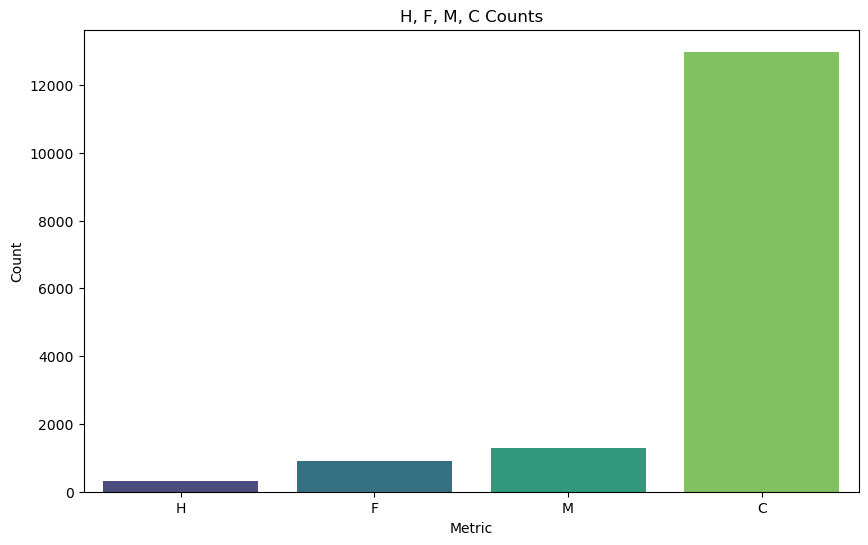

In [23]:
# # 평가
# print(classification_report(y_test, final_pred))
# print(confusion_matrix(y_test, final_pred))

# 최종 예측 결과를 데이터프레임에 추가
results_df = pd.DataFrame({'estimated_rank': final_pred.ravel(), 'rainfall_train.class_interval': np.array(y_test).ravel()})

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(results_df)

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")

# H, F, M, C 값 시각화
metrics = pd.DataFrame({'Metric': ['H', 'F', 'M', 'C'], 'Count': [H, F, M, C]})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Count', data=metrics, palette='viridis')
plt.title('H, F, M, C Counts')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.show()